# Homework 2: ATE Estimation with the voter turnout data

## Introduction

In this assignment, we'll be working with some of the data described in the paper [“Social Pressure and Voter Turnout: Evidence from a Large-Scale Field Experiment”](http://isps.yale.edu/sites/default/files/publication/2012/12/ISPS08-001.pdf) by Gerber et al. (2008).  We attained the data from this [Github repo](https://github.com/gsbDBI/ExperimentData/tree/master/Social), specifically this [file](https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/Social/ProcessedData/socialpresswgeooneperhh_NEIGH.csv). It's also included in the assignment zip file.  In this assignment we'll build several ATE estimators by reduction to two estimations from incomplete data, as discussed in lecture. Parts of this notebook are based on a [notebook](https://gsbdbi.github.io/ml_tutorial/ate_tutorial/ate_tutorial.html) from a tutorial/course on causal inference at Stanford GSB.  Although not necessary, you may find it interesting to refer to, as they give more details about the covariates, and they they cover some methods that we don't get into (and vice versa).

## Data prep

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import norm, sem
from scipy.interpolate import UnivariateSpline
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from numpy.random import default_rng

In [6]:
## Read the data, select some columns, and lightly process
df = pd.read_csv('sp.csv.xz')
cts_variables_names = ["yob", "hh_size", "totalpopulation_estimate",
                         "percent_male", "median_age",
                         "percent_62yearsandover",
                         "percent_white", "percent_black",
                         "percent_asian", "median_income",
                         "employ_20to64", "highschool", "bach_orhigher",
                         "percent_hispanicorlatino"]
binary_variables_names = ["sex","g2000", "g2002", "p2000", "p2002", "p2004"]
scaled_cts_covariates = StandardScaler().fit_transform(df[cts_variables_names])
binary_covariates = df[binary_variables_names]
d = pd.DataFrame(np.concatenate((scaled_cts_covariates, binary_covariates), axis=1), 
                        columns=cts_variables_names+binary_variables_names, index=df.index)
d["W"] = df["treat_neighbors"]
d["Y"] = df["outcome_voted"]

In [7]:
d['Y'].value_counts()

0    81803
1    38196
Name: Y, dtype: int64

### Problem 1: ATE for RCT
All individuals in this experiment had an equal probability of being assigned to the treatment group, so the difference-of-means will be a reasonable estimator for the average treatment effect (ATE).  Write a function that computes the difference-of-means estimator for the treatment effect, along with an approximate 95% confidence interval.  Apply it to the dataset d computed above and report the results.  Save the estimate of the ATE and the radius of the confidence interval for later use.

In [8]:
def get_diff_of_means(d, alpha=0.05):
    # TODO
    treated_Y = d[d['W']==1]['Y']
    control_Y =  d[d['W']==0]['Y']
    
    ate = treated_Y.mean()-control_Y.mean()
    var_dom = treated_Y.var()/len(treated_Y)+control_Y.var()/len(control_Y)
    std_dom = var_dom**.5
    
    ate_CI_radius = norm.ppf(1-alpha*2)*std_dom
    
    return ate,ate_CI_radius


ate, ate_CI_radius = get_diff_of_means(d, alpha=0.05)

In [9]:
print('ATE:',ate)
print('ATE Radius:',ate_CI_radius)

ATE: 0.08639696096960969
ATE Radius: 0.0047975910420401105


### Problem 2: ATE estimation with known confounders
In this problem we're going to take a relatively small and biased subsample of our full dataset and try to use that to estimate the ATE. Our approach is to reduce ATE estimation to estimating a mean in the MAR setting.

Below we give a function that takes a biased sample using an approach similar to [this one](https://gsbdbi.github.io/ml_tutorial/ate_tutorial/ate_tutorial.html#introducing_sampling_bias). The details aren't important for what follows.

In [43]:
likely_voters =  (((d['g2002'] == 1) & (d['sex'] == 0)) | (d['p2004'] == 1))
unlikely_voters_control = (~likely_voters) & (d["W"] == 0)
likely_voters_treatment = likely_voters & (d["W"] == 1)
print(likely_voters.mean())
def get_biased_sample(d, overall_subsample_rate=.03, bias_rate=.4, rng=default_rng(0)):
    keep_prob = overall_subsample_rate * np.ones(len(d))
    keep_prob[unlikely_voters_control] *= bias_rate
    keep_prob[likely_voters_treatment] *= bias_rate
    keep = rng.random(len(d)) <= keep_prob
    d_bias = d[keep]
    
    return d_bias

d_bias = get_biased_sample(d)
new_likely_voters =  (((d_bias['g2002'] == 1) & (d['sex'] == 0)) | (d['p2004'] == 1))
print(new_likely_voters.mean())
print(f"We've sampled {len(d_bias)} instances out of {len(d)}.")

0.6583804865040542
0.4248535404461704
We've sampled 2740 instances out of 119999.


#### Part A
Below we provide the function get_basic_MAR_estimators, which computes the complete-case mean and the IPW mean in the MAR setting with known propensity scores. You are to complete the get_ATE_estimators function below so that it *uses the get_basic_MAR_estimators function* and computes one ATE estimate for each type of estimator produced by get_basic_MAR_estimators (i.e. the complete-case mean and the IPW mean).  Use logistic regression to estimate the propensity scores from the data provided to the function.  Run the existing code block below to display the results.

In [14]:
def get_basic_MAR_estimators(Y, X, pi, R):
    """
    
    Args:
        Y (pd.Series): the measurement of the outcome Y_i
        X (pd.DataFrame): covariates, rows correspond to entries of Y
        R (pd.Series): boolean series indicating whether Y was observed
        pi (pd.Series): propensity scores corresponding to observations
    
    Returns:
        dict of estimator names and estimates for EY
    """
    est = {}
    n = len(Y)
    ## All the estimators below assume we know the pi (i.e. "missing by design")
    est["mean"] = np.mean(Y[R])
    est["ipw_mean"] = np.sum(Y[R] / pi[R]) / n
    
    return est

In [17]:
def get_ATE_estimators(Y, X, W, get_MAR_estimators=get_basic_MAR_estimators):
    """
    
    Args:
        Y (pd.Series): the measurement of the outcome Y_i
        X (pd.DataFrame): covariates, rows correspond to entries or Y
        W (pd.Series): 0/1 series indicating control (0) or treatment (1) assignment
        get_MAR_estimators: function behaving like get_basic_MAR_estimators above
    
    Returns:
        dict of ATE estimator names and estimates, same format as for get_MAR_estimators
    """   
    # TODO
    prop_model = LogisticRegression()
    prop_model.fit(X,W)
    propensities = prop_model.predict_proba(X)
    #print(model.classes_)
    pi_control, pi_treated = propensities[:,0],propensities[:,1]
    
    R_treated = W==1
    R_control = W==0
    
    est_control = get_MAR_estimators(Y,X,pi_control,R_control)
    est_treated = get_MAR_estimators(Y,X,pi_treated,R_treated)
    
    ate = {}
    for key in est_control:
        ate[key] = est_treated[key] - est_control[key]
    return ate

In [18]:
## Run the following and report 
d_bias = get_biased_sample(d, overall_subsample_rate=.03, bias_rate=.4, rng=default_rng(0))
X = d_bias.drop(columns=['W','Y'])
ate_est = get_ATE_estimators(Y=d_bias["Y"], X=X, W=d_bias["W"], get_MAR_estimators=get_basic_MAR_estimators)
print(ate_est)

{'mean': 0.03636661211129294, 'ipw_mean': 0.14150098309907239}


#### Part B
In this part we significantly expand our ATE estimators and see how they perform over repeated trials.  Complete get_MAR_estimators below to include 
- Self-normalized IPW mean
- Linear regression imputation
- IPW linear regression imputation (as defined in lecture)
- IW linear regression imputation (as defined in lecture)
- Augmented IPW using linear regression
- [Optional (not for credit): nonlinear regression, or any other variations you'd like to try]

Run the code below to assess performance of these estimators.

In [30]:
def get_MAR_estimators(Y, X, pi, R):
    """
    
    Args:
        Y (pd.Series): the measurement of the outcome Y_i
        X (pd.DataFrame): covariates, rows correspond to entries or Y
        R (pd.Series): boolean series indicating whether Y was observed
        pi (pd.Series): propensity scores corresponding to observations
    
    Returns:
        dict of estimator names and estimates for EY
    """
    est = {}
    n = len(Y)
    ## All the estimators below assume we know the pi (i.e. "missing by design")
    est["mean"] = np.mean(Y[R])
    est["ipw_mean"] = np.sum(Y[R] / pi[R]) / n
    est["sn_ipw_mean"] = np.sum(Y[R]/pi[R])/np.sum(1/pi[R])
    
    #Linear Imputation
    model = LinearRegression()
    model.fit(X[R],Y[R],)
    est["impute_lr"] = np.concatenate([model.predict(X[~R]),Y[R]]).mean()
    
    #Importance Weighting on the complete cases to incomplete cases, IW_linear
    weights = (1-pi)/pi
    model = LinearRegression()
    #fit on complete cases, but predict on missing cases, then average to get estimate for Y
    model.fit(X[R],Y[R],weights[R])
    est["impute_iw_lr"] = np.concatenate([model.predict(X[~R]),Y[R]]).mean()
    
    #Importance Weighting on the complete cases to ALL cases, IPW_Linear
    weights = 1/pi
    model = LinearRegression()
    #Fit on complete cases, predict on ALL cases, then average to get estimate for Y
    model.fit(X[R],Y[R],weights[R])
    est["impute_ipw_lr"] = model.predict(X).mean()
    
    #Augmented IPW
    #F is fit on the complete cases to predict on ONLY complete cases
    model = LinearRegression()
    model.fit(X[R],Y[R],)
    f_x = model.predict(X)
    
    est['a_ipw'] = ( np.sum( (Y*R)/pi - (f_x*R)/pi + f_x) )/n
    
    #Augmented IPW w/ IW
    #F is fit on the complete cases to predict on ALL Cases
    weights = 1/pi
    model = LinearRegression()
    model.fit(X[R],Y[R],weights[R])
    f_x = model.predict(X)
    
    est['a_ipw_IW'] = ( np.sum( (Y*R)/pi - (f_x*R)/pi + f_x) )/n
    
    ## TODO
    return est
    


In [31]:
## Run the following and report 
d_bias = get_biased_sample(d, overall_subsample_rate=.03, bias_rate=.4, rng=default_rng(0))
X = d_bias.drop(columns=['W','Y'])
ate_est = get_ATE_estimators(Y=d_bias["Y"], X=X, W=d_bias["W"], get_MAR_estimators=get_MAR_estimators)
print(ate_est)

{'mean': 0.03636661211129294, 'ipw_mean': 0.14150098309907239, 'sn_ipw_mean': 0.10043918758877857, 'impute_lr': 0.06586463436122314, 'impute_iw_lr': 0.07797247353871739, 'impute_ipw_lr': 0.07930786641863158, 'a_ipw': 0.09223360039649053, 'a_ipw_IW': 0.07930786641863136}


In [32]:
def get_estimator_stats(estimates, true_parameter_value=None):
    """
 
     Args:
        estimates (pd.DataFrame): each row corresponds to collection of estimates for a sample and
            each column corresponds to an estimator
        true_parameter_value (float): the true parameter value that we will be comparing estimates to
            
    Returns:
        pd.Dataframe where each row represents data about a single estimator
    """
    
    est_stat = []
    for est in estimates.columns:
        pred_means = estimates[est]
        stat = {}
        stat['stat'] = est
        stat['mean'] = np.mean(pred_means)
        stat['SD'] = np.std(pred_means)
        stat['SE'] = np.std(pred_means) / np.sqrt(len(pred_means))
        if true_parameter_value:
            stat['bias'] = stat['mean'] - true_parameter_value
            stat['RMSE'] = np.sqrt(np.mean((pred_means - true_parameter_value) ** 2))
        est_stat.append(stat)

    return pd.DataFrame(est_stat)


In [33]:
def run_experiments(sampler, num_repeats=10,rng=default_rng(0)):
    data_list = []
    num_obs_list = []
    for i in range(num_repeats): 
        d = sampler(rng)
        X = d.drop(columns=['W','Y'])
        ate_est = get_ATE_estimators(Y=d["Y"], X=X, W=d["W"], get_MAR_estimators=get_MAR_estimators)
        data_list.append(ate_est)
    results = pd.DataFrame(data_list)
    return results

In [34]:
def sampler(rng):
    return get_biased_sample(d, overall_subsample_rate=.06, bias_rate=.4, rng=rng)
rng = default_rng(0)
results = run_experiments(sampler, num_repeats=500, rng=rng) 

In [35]:
results_eval = get_estimator_stats(results, true_parameter_value=ate)
results_eval

,stat,mean,SD,SE,bias,RMSE
0,mean,0.033087,0.018351,0.000821,-0.053310,0.056380
1,ipw_mean,0.134785,0.028370,0.001269,0.048388,0.056091
2,sn_ipw_mean,0.101437,0.025028,0.001119,0.015040,0.029199
3,impute_lr,0.087300,0.022025,0.000985,0.000903,0.022043
4,impute_iw_lr,0.086868,0.022254,0.000995,0.000471,0.022259
5,impute_ipw_lr,0.086888,0.022261,0.000996,0.000491,0.022267
6,a_ipw,0.087040,0.022588,0.001010,0.000643,0.022597
7,a_ipw_IW,0.086888,0.022261,0.000996,0.000491,0.022267


#### Part C
You should see that the ATE estimate based on the IPW mean is significantly biased, and the bias seems to be driving most of the RMSE. In class we showed that the IPW mean is an unbiased estimator for EY in the MAR setting, and the corresponding ATE estimator is also unbiased.  Why are we seeing bias in this experiment?


We are seeing bias because of covariate shift.

Previously, we got a biased sample of the data in the function `get_biased_sample`. If we examine the code/method/link given, we see that we are introducing a _sampling bias based on the covariate $X$ and the treatment variable $W$_. In particular, this means that the specifically the value of $X$ has an influence on whether or the the data point shows up in return of the `get biased sample` function. 

Our results generated in part B of this problem used the "true value of ATE" as was calculated in problem 1. The results in problem 1 were generated using the full dataset, which has a certain distribution of covariates $X$. In Problem 2, we dropped some likely treated voters, and dropped some unlikely non-treated voters. Note that how likely voters were defined `likely_voters =  (((d['g2002'] == 1) & (d['sex'] == 0)) | (d['p2004'] == 1))` depends only on the covariates $X$.

Now, the code in the following cell shows that the ratio of likely voters before -> after dropping was 0.658 -> 0.424.

It is likely that the CATE(likely voter) is different than the CATE(non-likely voter), though we do not show this explicity. 

Both those statements imply that there is a significant degree of covariate shift, which affects the estimate for the full ATE.






In [47]:
likely_voters =  (((d['g2002'] == 1) & (d['sex'] == 0)) | (d['p2004'] == 1))
unlikely_voters_control = (~likely_voters) & (d["W"] == 0)
likely_voters_treatment = likely_voters & (d["W"] == 1)
print('Proportion of likely voters before dropping:', likely_voters.mean())
def get_biased_sample(d, overall_subsample_rate=.03, bias_rate=.4, rng=default_rng(0)):
    keep_prob = overall_subsample_rate * np.ones(len(d))
    keep_prob[unlikely_voters_control] *= bias_rate
    keep_prob[likely_voters_treatment] *= bias_rate
    keep = rng.random(len(d)) <= keep_prob
    d_bias = d[keep]
    
    return d_bias

d_bias = get_biased_sample(d)
new_likely_voters =  (((d_bias['g2002'] == 1) & (d['sex'] == 0)) | (d['p2004'] == 1))
print('Proportion of likely voters after dropping:', new_likely_voters.mean())
print(f"We've sampled {len(d_bias)} instances out of {len(d)}.")

Proportion of likely voters before dropping: 0.6583804865040542
Proportion of likely voters after dropping: 0.4248535404461704
We've sampled 2740 instances out of 119999.


### Problem 3: Bootstrap confidence intervals for ATE
Let's now consider a more realistic scenario, in which we only have a single sample to work with.  In this case it's very important to be able to include some form of uncertainty measure with our estimates.  In this problem we'll do this using the normal approximated bootstrap confidence intervals described in our module on CATEs. However, in this setting, rather than estimating the CATE, we're just estimating the ATE. 

#### Part A
Complete the function get_stratified_bootstrap_CI to generate 95% normal approximated bootstrap confidence intervals for each of the ATE estimators we've developed above. Execute the code below to test the function and produce the results as a table and in a plot.

In [36]:
from collections import defaultdict
from sklearn.utils import resample

In [37]:
def get_bootstrap_stats(boot_estimates, full_estimates, alpha=0.05):
    est_stat = []
    signif_level = -norm.ppf(alpha/2)
    for est in full_estimates:
        est_boot = np.array(boot_estimates[est])
        stat = {}
        stat['estimator'] = est
        stat['estimate'] = full_estimates[est]
        #stat['mean_boot'] = np.mean(est_boot)
        stat['SD'] = np.std(est_boot)
        stat['CI_radius'] = signif_level * stat['SD']
        stat['lower_ci'] = stat['estimate'] - stat['CI_radius']
        stat['upper_ci'] = stat['estimate'] + stat['CI_radius']
        est_stat.append(stat)

    return pd.DataFrame(est_stat)


def get_stratified_bootstrap_CI(Y, X, W, estimators, num_bootstrap=10, alpha=0.05):
    """
    Returns:
        pd.Dataframe with
            column "estimator" with the name of the estimator,
            column "estimate" which is the estimate based on (Y,X,W)
                which serves as the center of our bootstrap confidence intervals
            column "CI_radius" which is the radius of the confidence interval
            (additional columns may be included as you wish)
    """    
    #TODO
    n = len(Y)
    all_estimates = defaultdict(list)
    est_list = []
    treated_idx = (W==1).index
    control_idx = (W==0).index
    for ii in range(num_bootstrap):
        treated_idx_to_use = np.random.choice(treated_idx,size = len(Y),replace=True)
        control_idx_to_use = np.random.choice(control_idx,size = len(Y),replace=True)
        idx_to_use = np.concatenate([treated_idx_to_use,control_idx_to_use])
        Y_r = Y[idx_to_use] 
        X_r = X.loc[idx_to_use]
        W_r = W[idx_to_use] 
        
        est = get_ATE_estimators(Y_r, X_r, W_r, get_MAR_estimators=get_MAR_estimators)
        est_list.append(est)
    true_estimates = get_ATE_estimators(Y,X,W,get_MAR_estimators=get_MAR_estimators)
    bootstrap_est=pd.DataFrame(est_list)
    #display(bootstrap_est)
    
    return_df = get_bootstrap_stats(bootstrap_est,true_estimates,alpha=0.05)

    return return_df

    
        
        


A 95% confidence interval for the ATE based on the full dataset is 0.08639696096960969+/-0.0047975910420401105
       estimator  estimate        SD  CI_radius  lower_ci  upper_ci
0           mean  0.032720  0.012859   0.025204  0.007516  0.057924
1       ipw_mean  0.138417  0.022325   0.043756  0.094660  0.182173
2    sn_ipw_mean  0.093061  0.019295   0.037817  0.055245  0.130878
3      impute_lr  0.084381  0.015389   0.030162  0.054219  0.114543
4   impute_iw_lr  0.081245  0.015670   0.030713  0.050532  0.111958
5  impute_ipw_lr  0.080742  0.015770   0.030909  0.049832  0.111651
6          a_ipw  0.076795  0.016992   0.033305  0.043491  0.110100
7       a_ipw_IW  0.080742  0.015770   0.030909  0.049832  0.111651


[Text(0, 0, 'mean'),
 Text(0, 1, 'ipw_mean'),
 Text(0, 2, 'sn_ipw_mean'),
 Text(0, 3, 'impute_lr'),
 Text(0, 4, 'impute_iw_lr'),
 Text(0, 5, 'impute_ipw_lr'),
 Text(0, 6, 'a_ipw'),
 Text(0, 7, 'a_ipw_IW'),
 Text(0, 8, 'Full data estimate')]

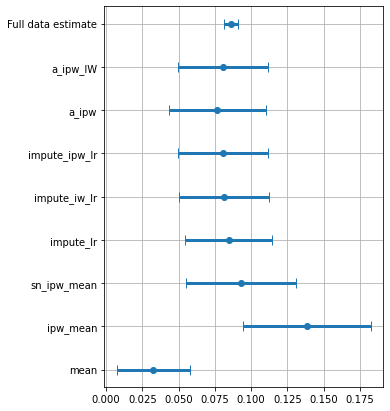

In [38]:
rng = default_rng(8)
d_samp = sampler(rng) # our single biased sample
X = d_samp.drop(columns=['W','Y'])
estimators = lambda Y, X, W: get_ATE_estimators(Y, X, W, get_MAR_estimators=get_MAR_estimators)
ci = get_stratified_bootstrap_CI(Y=d_samp["Y"], X=X, W=d_samp["W"], estimators=estimators, num_bootstrap=500)
print(f"A 95% confidence interval for the ATE based on the full dataset is {ate}+/-{ate_CI_radius}")
print(ci)
to_plot = ci[['estimator','estimate','CI_radius']]
to_plot = to_plot.append({'estimator':'Full data estimate','estimate':ate,'CI_radius':ate_CI_radius}, ignore_index=True)
fig, ax =plt.subplots(1,1, figsize=(5,7))
ax.errorbar(to_plot['estimate'], np.arange(len(to_plot)), \
            xerr=to_plot['CI_radius'], 
            fmt='o', elinewidth=3, capsize=5)
ax.grid('on')
ax.set_yticks(np.arange(len(to_plot)))
ax.set_yticklabels(to_plot["estimator"])